## Functions of dissimilarity

### Importation of the libraries

In [ ]:
import time
import os
import math
import csv
import importlib
from pathlib import Path
import numpy as np
import pinard as pn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from pinard import utils
from pinard import preprocessing as pp

from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.linear_model import RidgeCV, LinearRegression
from xgboost import XGBRegressor
from itertools import combinations
import dissimilarity_functions as dissim


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

### Importation of the datasets

In [3]:
# Function to load a CSV file with automatic separator detection

def load_csv_auto_sep(mode, data_source, type_data, verbose=True):
 
     # Regression: 'BeerOriginalExtract' or 'Digest_0.8' or 'YamProtein' //
    # Classification: 'CoffeeSpecies' or 'Malaria2024' or 'mDigest_custom3' or 'WhiskyConcentration' or 'YamMould'

    ## Importation of the datasets with the adapted path
    file_name = Path("Data/%s/%s"% (mode,data_source))
    full_path = str(file_name.resolve()).replace("\\", "/")
    path = full_path + "/%s.csv" % type_data

    with open(path, 'r', newline='', encoding='utf-8') as f:
        # Read a small portion of the file to detect the separator
        excerpt = f.read(1024)
        f.seek(0)  # return to the beginning of the file

        # Detection of the dialect
        dialect = csv.Sniffer().sniff(excerpt)
        sep = dialect.delimiter

        if verbose: print("Detected separator : %s" % sep)
        
        # Load the file with pandas
        df = pd.read_csv(f, delimiter=sep)

        if len(df.columns) > 1:
            # Drop the useless column if it exists
            df = df.drop(columns=[df.columns[1]])
        
        return df

In [4]:
mode = 'Regression'
data_source = 'BeerOriginalExtract'

Xcal = load_csv_auto_sep(mode=mode, data_source=data_source, type_data='Xcal')
Xval = load_csv_auto_sep(mode=mode, data_source=data_source, type_data='Xval')
Ycal = load_csv_auto_sep(mode=mode, data_source=data_source, type_data='Ycal')
Yval = load_csv_auto_sep(mode=mode, data_source=data_source, type_data='Yval')

print("Number of spectra for calibration: ", len(Ycal))
print("Number of spectra for test: ", len(Yval))
display(Xcal.head(5))

Detected separator : ;
Detected separator : ;
Detected separator : 
Detected separator : 
Number of spectra for calibration:  40
Number of spectra for test:  20


,V1,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V567,V568,V569,V570,V571,V572,V573,V574,V575,V576
0,0.245288,0.258437,0.265449,0.272342,0.280249,0.288323,0.297118,0.307861,0.319456,0.333941,...,3.679895,3.654557,3.653983,3.714209,3.669642,3.625521,3.647152,3.573585,3.623088,3.679775
1,0.242613,0.255609,0.262486,0.269311,0.277092,0.285063,0.293715,0.304371,0.315839,0.330161,...,3.632740,3.738945,3.601677,3.592955,3.606268,3.657218,3.632019,3.660901,3.635919,3.671539
2,0.241651,0.254431,0.261214,0.267891,0.275535,0.283370,0.291886,0.302335,0.313625,0.327746,...,3.563812,3.622122,3.617598,3.652315,3.590150,3.710362,3.630672,3.653063,3.566837,3.704355
3,0.239650,0.252350,0.259107,0.265761,0.273390,0.281214,0.289725,0.300164,0.311455,0.325609,...,3.583575,3.620621,3.682378,3.681044,3.650404,3.645983,3.633222,3.668727,3.650432,3.687260
4,0.240787,0.253521,0.260278,0.266935,0.274576,0.282420,0.290953,0.301394,0.312720,0.326881,...,3.650906,3.728940,3.614735,3.618842,3.656746,3.622961,3.560679,3.710902,3.653769,3.663029


### Tableaux récupatulatifs pour les jeux de données

In [4]:
info_datasets = {}
names = ['BeerOriginalExtract', 'Digest_0.8', 'YamProtein', 'CoffeeSpecies', 'Malaria2024', 'mDigest_custom3', 'WhiskyConcentration', 'YamMould']

for ind, name in enumerate(names):
    if ind < 3: 
        mode = 'Regression'
    else:
        mode = 'Classification'
    
    x = load_csv_auto_sep(mode=mode, data_source=name, type_data='Xcal', verbose=False)
    y = load_csv_auto_sep(mode=mode, data_source=name, type_data='Xval', verbose=False)

    size_cal, size_val = len(x), len(y)
    nb_var = len(x.columns)

    if mode == 'Regression':
        nb_classes = None
        prop_classes_cal = None
        prop_classes_val = None
    else:
        # We need to get more information about the classes
        y_cal = load_csv_auto_sep(mode=mode, data_source=name, type_data='Ycal', verbose=False)
        y_val = load_csv_auto_sep(mode=mode, data_source=name, type_data='Yval', verbose=False)

        # Calculate the number of classes in the calibration and validation sets
        nb_classes_cal, nb_classes_val = int(y_cal.nunique()), int(y_val.nunique())
        if nb_classes_cal != nb_classes_val:
            nb_classes = f"Cal: {nb_classes_cal}, Val: {nb_classes_val}"
        else:
            nb_classes = str(nb_classes_cal)

        # Calculate the proportion of each class in the calibration and validation sets
        prop_classes_cal = np.round(y_cal.value_counts(normalize=True).values,2)
        prop_classes_val = np.round(y_val.value_counts(normalize=True).values,2)

    # Store the information in the dictionary
    info_datasets[name] = (mode, size_cal, size_val, nb_var, nb_classes, prop_classes_cal, prop_classes_val)


comparatif = pd.DataFrame([
    {
        "Nom": name,
        "Type": mode,
        "Nombre de spectres": size_cal+size_val,
        "Nombre de spectres de calibration": size_cal,
        "Nombre de spectres de validation": size_val,
        "Nombre de variables": nb_var, 
        "Nombre de classes": nb_classes if mode == 'Classification' else None,
        "Proportions classes calibration": prop_classes_cal if mode == 'Classification' else None, 
        "Proportions classes validation": prop_classes_val if mode == 'Classification' else None
    }
    for name, (mode, size_cal, size_val, nb_var, nb_classes, prop_classes_cal, prop_classes_val) in info_datasets.items()
])

display(comparatif)

,Nom,Type,Nombre de spectres,Nombre de spectres de calibration,Nombre de spectres de validation,Nombre de variables,Nombre de classes,Proportions classes calibration,Proportions classes validation
0,BeerOriginalExtract,Regression,60,40,20,575,None,None,None
1,Digest_0.8,Regression,1876,1504,372,948,None,None,None
2,YamProtein,Regression,1032,784,248,1049,None,None,None
3,CoffeeSpecies,Classification,56,28,28,285,2,"[0.5, 0.5]","[0.54, 0.46]"
4,Malaria2024,Classification,4281,2996,1285,1664,2,"[0.96, 0.04]","[0.95, 0.05]"
5,mDigest_custom3,Classification,469,376,93,948,3,"[0.66, 0.21, 0.13]","[0.67, 0.2, 0.13]"
6,WhiskyConcentration,Classification,1578,1112,466,1751,4,"[0.25, 0.25, 0.25, 0.25]","[0.25, 0.25, 0.25, 0.25]"
7,YamMould,Classification,581,359,222,1049,2,"[0.63, 0.37]","[0.59, 0.41]"


### Fucntion to plot diverse sets of spectra

In [5]:
def plot_spectra(X, names, title='Visualization of the spectra'):
    if isinstance(X, pd.DataFrame):
        X = [X.values]
    elif isinstance(X, np.ndarray):
            X = [X]

    plt.figure(figsize=(10, 5))
    colors = sns.color_palette(palette = "Paired")
    for i, dataset in enumerate(X):
         plt.plot(dataset.T, color=colors[i])
         plt.plot([], [], color=colors[i], label=names[i])

    plt.legend(loc='upper left', fontsize='small')
    plt.title(title)
    plt.xlabel('Wavelength')
    plt.ylabel('Absorbance')
    plt.xticks(np.arange(0, dataset.shape[1], dataset.shape[1]//10), rotation=45)
    plt.show(block=False)

### Test of pipelines with Pinard

In [4]:
# Simple pipeline declaration
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('preprocessing', pp.SavitzkyGolay()),
    ('pls', PLSRegression(n_components=10, scale=False))
    ])

# Transform the data with the desired part of the pipeline
Xcal_transformed = pipeline[1].fit_transform(Xcal)

c:\Users\reiter\CIRAD_PhD_Robin\CIRAD_PhD_Robin\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SavitzkyGolay was fitted without feature names
  warnings.warn(


### Visualize the spectra after preprocessing

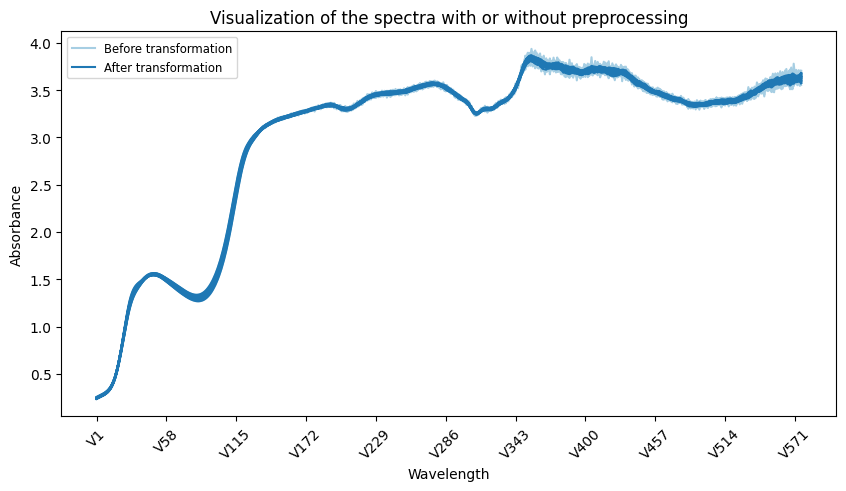

In [7]:
plot_spectra([Xcal, Xcal_transformed], 
             names = ['Before transformation', 'After transformation'], 
             title= 'Visualization of the spectra with or without preprocessing')
plt.show()

### Test on diverse preprocessing methods

In [ ]:
# Dictionnary of preprocessing methods to be applied

preprocessings = {
    'Savitzky-Golay (0)': pp.SavitzkyGolay(),
    'Savitzky-Golay (1)': pp.SavitzkyGolay(deriv=1),
    'Savitzky-Golay (2)': pp.SavitzkyGolay(deriv=2),
    'Savitzky-Golay (3)': pp.SavitzkyGolay(deriv=3),
    'Savitzky-Golay (4)': pp.SavitzkyGolay(deriv=4),
    'Savitzky-Golay (5)': pp.SavitzkyGolay(deriv=5),
    'Savitzky-Golay (6)': pp.SavitzkyGolay(deriv=6),
    'Gaussian (1, 2)': pp.Gaussian(order = 1, sigma = 2),
    'Gaussian (2, 1)': pp.Gaussian(order = 2, sigma = 1),
    'Gaussian (3, 1)': pp.Gaussian(order = 3, sigma = 1),
    'Gaussian (4, 1)': pp.Gaussian(order = 4, sigma = 1),
    'Gaussian (5, 1)': pp.Gaussian(order = 5, sigma = 1)
}

### Dissimilarity with the Kolmogorov-Smirnov test

In [ ]:
dict, close_preprocessings = dissim.compare_preprocessings(preprocessings, Xcal, distance_fn=dissim.dissim_KS)

print(close_preprocessings)

[('Savitzky-Golay (1)', 'Gaussian (1, 2)'), ('Savitzky-Golay (4)', 'Savitzky-Golay (5)'), ('Savitzky-Golay (4)', 'Savitzky-Golay (6)'), ('Savitzky-Golay (5)', 'Savitzky-Golay (6)'), ('Gaussian (2, 1)', 'Gaussian (3, 1)')]


### Dissimilarity with a function on datasets' meta attributes 

In this section we refer to the article [Raynaut et al., 2017](https://hal.science/hal-02451041/document).

In [ ]:
# Dictionnary of preprocessing methods to be applied

preprocessings = {
    'Savitzky-Golay (0)': pp.SavitzkyGolay(),
    'Savitzky-Golay (1)': pp.SavitzkyGolay(deriv=1),
    'Savitzky-Golay (2)': pp.SavitzkyGolay(deriv=2),
    'Savitzky-Golay (3)': pp.SavitzkyGolay(deriv=3),
    'Savitzky-Golay (4)': pp.SavitzkyGolay(deriv=4),
    'Savitzky-Golay (5)': pp.SavitzkyGolay(deriv=5),
    'Savitzky-Golay (6)': pp.SavitzkyGolay(deriv=6),
    'Gaussian (1, 2)': pp.Gaussian(order = 1, sigma = 2),
    'Gaussian (2, 1)': pp.Gaussian(order = 2, sigma = 1),
    'Gaussian (3, 1)': pp.Gaussian(order = 3, sigma = 1),
    'Gaussian (4, 1)': pp.Gaussian(order = 4, sigma = 1),
    'Gaussian (5, 1)': pp.Gaussian(order = 5, sigma = 1)
}

In [ ]:
dict, close_preprocessings = dissim.compare_preprocessings(preprocessings, Xcal, distance_fn=dissim.dissim_meta_att_var, normalize_dissim=True)

print(close_preprocessings)

[('Savitzky-Golay (0)', 'Savitzky-Golay (1)'), ('Savitzky-Golay (0)', 'Savitzky-Golay (2)'), ('Savitzky-Golay (0)', 'Savitzky-Golay (3)'), ('Savitzky-Golay (0)', 'Gaussian (1, 2)'), ('Savitzky-Golay (0)', 'Gaussian (2, 1)'), ('Savitzky-Golay (0)', 'Gaussian (3, 1)'), ('Savitzky-Golay (0)', 'Gaussian (4, 1)'), ('Savitzky-Golay (0)', 'Gaussian (5, 1)'), ('Savitzky-Golay (1)', 'Savitzky-Golay (2)'), ('Savitzky-Golay (1)', 'Savitzky-Golay (3)'), ('Savitzky-Golay (1)', 'Gaussian (1, 2)'), ('Savitzky-Golay (1)', 'Gaussian (2, 1)'), ('Savitzky-Golay (1)', 'Gaussian (3, 1)'), ('Savitzky-Golay (1)', 'Gaussian (4, 1)'), ('Savitzky-Golay (1)', 'Gaussian (5, 1)'), ('Savitzky-Golay (2)', 'Savitzky-Golay (3)'), ('Savitzky-Golay (2)', 'Gaussian (1, 2)'), ('Savitzky-Golay (2)', 'Gaussian (2, 1)'), ('Savitzky-Golay (2)', 'Gaussian (3, 1)'), ('Savitzky-Golay (2)', 'Gaussian (4, 1)'), ('Savitzky-Golay (2)', 'Gaussian (5, 1)'), ('Savitzky-Golay (3)', 'Gaussian (1, 2)'), ('Savitzky-Golay (3)', 'Gaussian (2

### Comparison between dissimilarity functions on preprocessing pairs considered as close

In [ ]:
# Dictionnary of preprocessing methods to be applied

preprocessings = {
    'Savitzky-Golay (0)': pp.SavitzkyGolay(),
    'Savitzky-Golay (1)': pp.SavitzkyGolay(deriv=1),
    'Savitzky-Golay (2)': pp.SavitzkyGolay(deriv=2),
    'Savitzky-Golay (3)': pp.SavitzkyGolay(deriv=3),
    'Savitzky-Golay (4)': pp.SavitzkyGolay(deriv=4),
    'Savitzky-Golay (5)': pp.SavitzkyGolay(deriv=5),
    'Savitzky-Golay (6)': pp.SavitzkyGolay(deriv=6),
    'Gaussian (1, 2)': pp.Gaussian(order = 1, sigma = 2),
    'Gaussian (2, 1)': pp.Gaussian(order = 2, sigma = 1),
    'Gaussian (3, 1)': pp.Gaussian(order = 3, sigma = 1),
    'Gaussian (4, 1)': pp.Gaussian(order = 4, sigma = 1),
    'Gaussian (5, 1)': pp.Gaussian(order = 5, sigma = 1)
}

In [ ]:
dissim = importlib.import_module('dissimilarity_functions')
importlib.reload(dissim)

# Get the list of close preprocessings with Kennard-Stone dissimilarity
start_time = time.time()
dict_KS, close_preprocessings_KS = dissim.compare_preprocessings(preprocessings, Xcal, distance_fn=dissim.dissim_KS, normalize_dissim=False)
elapsed_time_KS = time.time() - start_time
print("Number of close pairs found : ", len(close_preprocessings_KS))
print("Kolmogorov-Smirnov dissimilarity : ", close_preprocessings_KS)
print("Time required : ", round(elapsed_time_KS,2), "seconds")
print("-" * 50)

Number of close pairs found :  5
Kennard-Stone dissimilarity :  [('Savitzky-Golay (1)', 'Gaussian (1, 2)'), ('Savitzky-Golay (4)', 'Savitzky-Golay (5)'), ('Savitzky-Golay (4)', 'Savitzky-Golay (6)'), ('Savitzky-Golay (5)', 'Savitzky-Golay (6)'), ('Gaussian (2, 1)', 'Gaussian (3, 1)')]
Time required :  1.72 seconds
--------------------------------------------------
0.0


In [23]:
print(list(dict_KS.values()))
np.percentile(list(dict_KS.values()), 10)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9998260869565219, 0.43408695652173906, 0.48726086956521736, 0.6196521739130434, 0.6196521739130434, 0.6196521739130434, 0.05634782608695652, 0.2376521739130435, 0.22826086956521738, 0.30565217391304345, 0.23686956521739128, 0.10956521739130434, 0.5166521739130434, 0.5166521739130434, 0.5166521739130434, 0.42200000000000004, 0.24130434782608692, 0.24230434782608695, 0.4665217391304347, 0.35, 0.5585652173913044, 0.5585652173913044, 0.5585652173913044, 0.48160869565217396, 0.29134782608695653, 0.2824782608695652, 0.5152608695652173, 0.3792608695652174, 0.0, 0.0, 0.6314347826086957, 0.5132173913043478, 0.5183913043478261, 0.6749565217391305, 0.5114782608695652, 0.0, 0.6314347826086957, 0.5132173913043478, 0.5183913043478261, 0.6749565217391305, 0.5114782608695652, 0.6314347826086957, 0.5132173913043478, 0.5183913043478261, 0.6749565217391305, 0.5114782608695652, 0.22447826086956518, 0.2267826086956522, 0.31526086956521737, 0.260652173913

np.float64(0.19043478260869565)

#### With a fixed threshold to detect closeness

In [ ]:
dissim = importlib.import_module('fonctions_dissimilarite')
importlib.reload(dissim)

# Get the list of close preprocessings with Kennard-Stone dissimilarity
start_time = time.time()
dict_KS, close_preprocessings_KS = dissim.compare_preprocessings(preprocessings, Xcal, distance_fn=dissim.dissim_KS, normalize_dissim=False)
elapsed_time_KS = time.time() - start_time
print("Number of close pairs found : ", len(close_preprocessings_KS))
print("KS dissimilarity : ", close_preprocessings_KS)
print("Time required : ", round(elapsed_time_KS,2), "seconds")
print("-" * 50)

# Get the list of close preprocessings with meta-attributes dissimilarity
start_time = time.time()
dict_meta, close_preprocessings_meta = dissim.compare_preprocessings(preprocessings, Xcal, distance_fn=dissim.dissim_meta_att_var, normalize_dissim=True)
elapsed_time_meta = time.time() - start_time
print("Number of close pairs found : ", len(close_preprocessings_meta))
print("Meta-attributes dissimilarity : ", close_preprocessings_meta)
print("Time required : ", round(elapsed_time_meta,2) , "seconds")

Number of close pairs found :  5
Kennard-Stone dissimilarity :  [('Savitzky-Golay (1)', 'Gaussian (1, 2)'), ('Savitzky-Golay (4)', 'Savitzky-Golay (5)'), ('Savitzky-Golay (4)', 'Savitzky-Golay (6)'), ('Savitzky-Golay (5)', 'Savitzky-Golay (6)'), ('Gaussian (2, 1)', 'Gaussian (3, 1)')]
Time required :  1.73 seconds
--------------------------------------------------
Number of close pairs found :  65
Meta-attributes dissimilarity :  [('Savitzky-Golay (0)', 'Savitzky-Golay (1)'), ('Savitzky-Golay (0)', 'Savitzky-Golay (2)'), ('Savitzky-Golay (0)', 'Savitzky-Golay (3)'), ('Savitzky-Golay (0)', 'Savitzky-Golay (4)'), ('Savitzky-Golay (0)', 'Savitzky-Golay (5)'), ('Savitzky-Golay (0)', 'Savitzky-Golay (6)'), ('Savitzky-Golay (0)', 'Gaussian (1, 2)'), ('Savitzky-Golay (0)', 'Gaussian (2, 1)'), ('Savitzky-Golay (0)', 'Gaussian (3, 1)'), ('Savitzky-Golay (0)', 'Gaussian (4, 1)'), ('Savitzky-Golay (0)', 'Gaussian (5, 1)'), ('Savitzky-Golay (1)', 'Savitzky-Golay (2)'), ('Savitzky-Golay (1)', 'Savi

#### With a threshold based on the proportion of preprocessing pairs to consider being close

The tests below are not performed on the same database than above.

In [ ]:
dissim = importlib.import_module('fonctions_dissimilarite')
importlib.reload(dissim)

# Get the list of close preprocessings with Kennard-Stone dissimilarity
start_time = time.time()
dict_KS, close_preprocessings_KS = dissim.compare_preprocessings(preprocessings, Xcal, distance_fn=dissim.dissim_KS, normalize_dissim=False, threshold=("proportion", 0.1))
elapsed_time_KS = time.time() - start_time
print("Number of close pairs found : ", len(close_preprocessings_KS))
print("KS dissimilarity : ", close_preprocessings_KS)
print("Time required : ", round(elapsed_time_KS,2), "seconds")
print("-" * 50)

# Get the list of close preprocessings with meta-attributes dissimilarity
start_time = time.time()
dict_meta, close_preprocessings_meta = dissim.compare_preprocessings(preprocessings, Xcal, distance_fn=dissim.dissim_meta_att_var, normalize_dissim=True, threshold=("proportion", 0.1))
elapsed_time_meta = time.time() - start_time
print("Number of close pairs found : ", len(close_preprocessings_meta))
print("Meta-attributes dissimilarity : ", close_preprocessings_meta)
print("Time required : ", round(elapsed_time_meta,2) , "seconds")

Number of close pairs found :  7
Kennard-Stone dissimilarity :  [('Savitzky-Golay (1)', 'Gaussian (1, 2)'), ('Savitzky-Golay (2)', 'Savitzky-Golay (3)'), ('Savitzky-Golay (4)', 'Savitzky-Golay (5)'), ('Savitzky-Golay (4)', 'Savitzky-Golay (6)'), ('Savitzky-Golay (5)', 'Savitzky-Golay (6)'), ('Gaussian (2, 1)', 'Gaussian (3, 1)'), ('Gaussian (3, 1)', 'Gaussian (5, 1)')]
Time required :  2.16 seconds
--------------------------------------------------
Number of close pairs found :  7
Meta-attributes dissimilarity :  [('Savitzky-Golay (0)', 'Savitzky-Golay (1)'), ('Savitzky-Golay (0)', 'Savitzky-Golay (2)'), ('Savitzky-Golay (0)', 'Savitzky-Golay (3)'), ('Savitzky-Golay (0)', 'Savitzky-Golay (4)'), ('Savitzky-Golay (4)', 'Savitzky-Golay (5)'), ('Savitzky-Golay (4)', 'Savitzky-Golay (6)'), ('Savitzky-Golay (5)', 'Savitzky-Golay (6)')]
Time required :  13.35 seconds
